In [1]:
# # Modèle de classification SVM

# # Chargement de la donnée:

import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()
votes.head(2)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,share_2008_democrat,share_2008_other,share_2008_republican,share_2012_democrat,share_2012_other,share_2012_republican,share_2016_democrat,share_2016_other,share_2016_republican,winner
0,29,227,00758566,0500000US29227,29227,Worth,06,690564983,493903,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",...,0.363714,0.034072,0.602215,0.325382,0.041031,0.633588,0.186424,0.041109,0.772467,republican
1,31,061,00835852,0500000US31061,31061,Franklin,06,1491355860,487899,"POLYGON ((-99.1794 40.35068, -98.72683 40.3504...",...,0.284794,0.019974,0.695232,0.250000,0.026042,0.723958,0.149432,0.045427,0.805140,republican


In [5]:
# # Exercice 1:

import pandas as pd
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# # 1.1. Création de la dummy y de victoire des républicains
votes["y"] = (votes["votes_gop"] > votes["votes_dem"]).astype(int)

# # 1.2. Création des échantillons d'entraînement et de validation
xvars = [
    "Unemployment_rate_2019",
    "Median_Household_Income_2019",
    "Percent of adults with less than a high school diploma, 2015-19",
    "Percent of adults with a bachelor's degree or higher, 2015-19",
]

df = votes.loc[:, ["y"] + xvars]

X_train, X_test, y_train, y_test = train_test_split(
    df[xvars], df[["y"]].values.ravel(), test_size=0.2, random_state=123
)
# X_train.head()
# y_test

# # 1.3. Entraînement du modèle et performances
clf = svm.SVC(kernel="linear", C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

out = pd.DataFrame.from_dict(
    {
        "Accuracy": [sc_accuracy],
        "Recall": [sc_recall],
        "Precision": [sc_precision],
        "F1": [sc_f1],
    },
    orient="index",
    columns=["Score"],
)
print(out.to_markdown())

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.882637 |
| Recall    | 0.897297 |
| Precision | 0.968872 |
| F1        | 0.931712 |


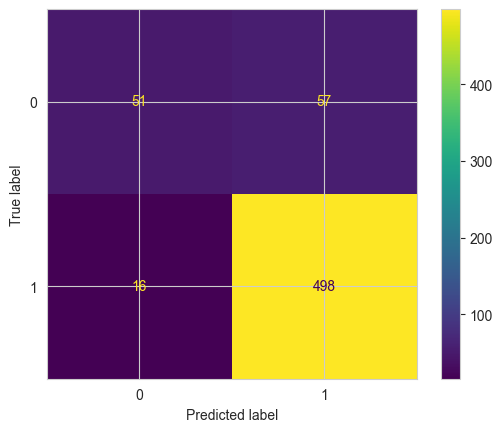

In [3]:
# # 1.4. Matrice de confusion

import matplotlib.pyplot as plt

predictions = clf.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf.classes_
)
disp.plot()

# Réponse : Notre classifieur manque totalement les labels 0, qui sont minoritaires.
# Une raison possible ? L'échelle des variables : le revenu a une
# distribution qui peut écraser celle des autres variables,
# dans un modèle linéaire. Il faut donc, a minima,
# standardiser les variables.

plt.savefig("confusion_matrix.png")

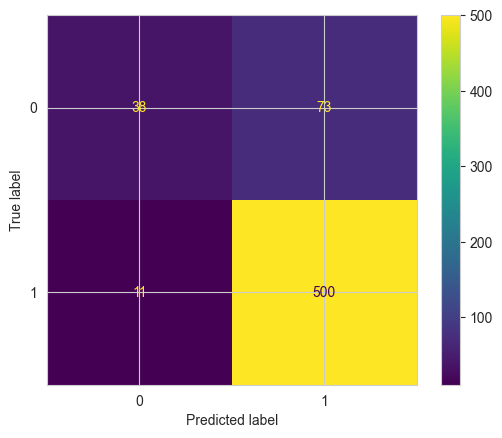

In [9]:
# # 1.5. Refaire les questions précédentes avec des variables normalisées.
import sklearn.preprocessing as preprocessing

X = df[xvars]
y = df[["y"]]
scaler = preprocessing.StandardScaler().fit(X)  # Ici on standardise
X = scaler.transform(X)  # Ici on standardise

X_train, X_test, y_train, y_test = train_test_split(
    X, y.values.ravel(), test_size=0.2, random_state=0
)

clf = svm.SVC(kernel="linear", C=1).fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=clf.classes_
)
disp.plot()

# Réponse : Non, standardiser les variables n'apporte pas de gain
# Il faut donc aller plus loin : le problème ne vient pas de l'échelle mais du choix des variables.
# C'est pour cette raison que l'étape de sélection de variable est cruciale.

plt.savefig("confusion_matrix2.png")